# Final
Feature Engineering is the key.

  
reference:  
https://www.kaggle.com/mjbahmani/statistical-analysis-for-elo  
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82055  
https://www.kaggle.com/chauhuynh/my-first-kernel-3-699  
https://www.kaggle.com/fabiendaniel/elo-world  
https://www.kaggle.com/raddar/target-true-meaning-revealed  
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82036#479038  
https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/  
https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering this is really helpfull  
https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

lightgbm params tuning:
https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823

datetime feature  
https://datascience.stackexchange.com/questions/27273/does-it-make-sense-that-datetime-encodes-one-hot-vector-like-one-hot-encoding-or

### Plan
After the analysis of mid-term project, we achieved a performance (RMSE) at 3.6524 on validation dataset using lightGBM model. Now we need to think can we do better on it? So we are planning to conduct the analysis further:
1. Can we get better score by using different or more features?
2. Can we get better score by optimizing the model?
3. Can we get better score by dealing with outliers more properly?
4. we need to do CV.
5. Xgboost/Catboost.


In [1]:
import pandas as pd
import os
import numpy as np
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
# import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

print(os.listdir("../data"))

['Data_Dictionary.xlsx', 'new_merchant_transactions.csv', 'test.csv', '~$Data_Dictionary.xlsx', 'merchants.csv', 'historical_transactions.csv', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


### Load Data

In [2]:
train_raw = pd.read_csv('../data/train.csv')
test_raw = pd.read_csv('../data/test.csv')
merchants_raw = pd.read_csv('../data/merchants.csv')
historical_transactions_raw = pd.read_csv('../data/historical_transactions.csv')
new_transactions_raw = pd.read_csv('../data/new_merchant_transactions.csv')
print('...loaded')

...loaded


In [3]:
# assign to new dataframe, save the raw data to be able to reuse again
train = train_raw
train.name = 'train data'
test = test_raw
test.name = 'test data'
historical_transactions = historical_transactions_raw
historical_transactions.name = 'historical transaction data'
new_transactions = new_transactions_raw
new_transactions.name = 'new transaction data'
merchants = merchants_raw
merchants.name = 'merchants data'

### Fill Null Data

In [4]:
# view NA data
print("train set NA data {}".format(train.isna().sum()))
print("test set NA data {}".format(test.isna().sum()))
print("new transaction set NA data {}".format(new_transactions.isna().sum()))
print("historical transaction set NA data {}".format(historical_transactions.isna().sum()))

train set NA data first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64
test set NA data first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64
new transaction set NA data authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64
historical transaction set NA data authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
categ

In [5]:
# helper function to fill na data with random value in the same column with on-NaN data
from random import choices

def randomiseMissingData(df):
    "randomise missing data for DataFrame (within a column)"
    for col in df.columns:
        data = df[col]
        mask = data.isna()
        samples = choices( data[~mask].values , k = mask.sum() )
        data[mask] = samples

In [6]:
# fill the NA data, this will take some time

for df in [historical_transactions, new_transactions]:
    print('fill NA data in {}'.format(df.name))
    randomiseMissingData(df)
print('...done')

fill NA data in historical transaction data
fill NA data in new transaction data
...done


In [7]:
# view NA data again
print("train set NA data {}".format(train.isna().sum()))
print("test set NA data {}".format(test.isna().sum()))
print("new transaction set NA data {}".format(new_transactions.isna().sum()))
print("historical transaction set NA data {}".format(historical_transactions.isna().sum()))

train set NA data first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64
test set NA data first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64
new transaction set NA data authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
purchase_amount         0
purchase_date           0
category_2              0
state_id                0
subsector_id            0
dtype: int64
historical transaction set NA data authorized_flag         0
card_id                 0
city_id                 0
category_1              0
installments            0
category_3              0
merchant_category_id    0
merchant_id             0
month_lag               0
p

In [8]:
# a helper function to save memory usage, u don't need to understand this one
# @input dataframe
# @return dataframe
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)


### Feature Extraction

Manual feature engineering can be a tedious process (which is why we use automated feature engineering with featuretools!) and often relies on domain expertise. I will concentrate of getting as much info as possible into the final training dataframe. The idea is that the model will then pick up on which features are important rather than us having to decide that. Basically, our approach is to make as many features as possible and then give them all to the model to use! Later, we can perform feature reduction using the feature importances from the model or other techniques such as PCA.

In [10]:
# print all current features
print(list(train))
print(list(test))
print(list(historical_transactions))
print(list(new_transactions))

['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3', 'target']
['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3']
['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments', 'category_3', 'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount', 'purchase_date', 'category_2', 'state_id', 'subsector_id']
['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments', 'category_3', 'merchant_category_id', 'merchant_id', 'month_lag', 'purchase_amount', 'purchase_date', 'category_2', 'state_id', 'subsector_id']


We need to understand the feature now.
1. the train dataset, we can see that it has card_id, this should be the unique id we can use for user profile, and group or aggregate the data w.r.t this feature. the feature_# in the data_dictionary descibed as Anonymized card categorical feature, we need to understand it later.
2. historical and new transactions. these two dataset have similar data structure.  
    a. 'purchase_date': max','min', require feature extraction.
        - 'month','hour','weekofyear','dayofweek','year', require no further process
        - 'weekend': 'sum', 'mean'
    b. 'merchant_id', 'merchant_category_id', 'subsector_id' need no more process.  
    c. 'purchase_amount': 'sum','max','min','mean','var'.  
    d. 'month_lag': 'max','min','mean','var'  
    e. 'month_diff': 'mean'  
    f. 'authorized_flag': 'sum, 'mean'  
    g. 'category_1': 'sum', 'mean'  
    h. 'category_2': 'mean'  
    i. 'category_3': 'mean'  
    j. 'card_id': 'size'

In [11]:
# helper function, create new column
def create_column(prefix, aggs):
    return [prefix + '_' + key + '_' + agg for key in aggs.keys() for agg in aggs[key]]

In [12]:
datetime.datetime.today()

datetime.datetime(2019, 4, 29, 0, 27, 30, 310330)

In [13]:
## main data preprocessing block

# 1. One important feature here is purchase_date feature, we need to extract it into year, month,
# week of year, day of week, weekend, hour
# 2. get time difference to today which 
# 3. normalize binary data to 1/0 int


for df in [historical_transactions, new_transactions]:

    # date conversion
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df['purchase_date'].dt.dayofweek >= 5).astype(int) # 0-5 week day
    df['hour'] = df['purchase_date'].dt.hour

    ## time difference
    # https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

    # normalization
    # TODO still not well done here
    df['authorized_flag'] = df['authorized_flag'].map({'Y': 1, 'N': 0})
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0})

### Feature aggregation
`groupby`: group a dataframe by a column. In this case we will group by the `card_id`.  
`agg`: perform a calculation on the grouped data such as taking the `mean` of columns. We can either call the function directly (grouped_df.mean()) or use the agg function together with a list of transforms (`grouped_df.agg([mean, max, min, sum])`)  
`merge`: match the aggregated statistics to the appropriate client. We need to merge the original training data with the calculated stats on the `card_id` column.

In [14]:
# create aggregation columns (features)
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['card_id'] = ['size']

aggs['category_1'] = ['sum', 'mean']

for col in ['category_2','category_3']:
    aggs[col+'_mean'] = ['mean'] 

In [15]:
aggs

{'month': ['nunique'],
 'hour': ['nunique'],
 'weekofyear': ['nunique'],
 'dayofweek': ['nunique'],
 'year': ['nunique'],
 'subsector_id': ['nunique'],
 'merchant_id': ['nunique'],
 'merchant_category_id': ['nunique'],
 'purchase_amount': ['sum', 'max', 'min', 'mean', 'var'],
 'installments': ['sum', 'max', 'min', 'mean', 'var'],
 'purchase_date': ['max', 'min'],
 'month_lag': ['max', 'min', 'mean', 'var'],
 'month_diff': ['mean'],
 'authorized_flag': ['sum', 'mean'],
 'weekend': ['sum', 'mean'],
 'card_id': ['size'],
 'category_1': ['sum', 'mean'],
 'category_2_mean': ['mean'],
 'category_3_mean': ['mean']}

In [16]:
# historical transactions data feature engineering
#
# append a column to historical transactions first
for col in ['category_2', 'category_3']:
     historical_transactions[col + '_mean'] = \
        historical_transactions.groupby([col])['purchase_amount'].transform('mean')

# historical transaction features
hist_columns = create_column('hist', aggs)

hist_trans_agg = historical_transactions.groupby('card_id').agg(aggs)
hist_trans_agg.columns = hist_columns
hist_trans_agg.reset_index(drop=False, inplace=False)
hist_trans_agg['hist_purchase_date_diff'] = \
    (hist_trans_agg['hist_purchase_date_max'] - hist_trans_agg['hist_purchase_date_min']).dt.days
hist_trans_agg['hist_purchase_date_average'] = \
    (hist_trans_agg['hist_purchase_date_diff']) / hist_trans_agg['hist_card_id_size']
hist_trans_agg['hist_purchase_date_uptonow'] = \
    (datetime.datetime.today() - hist_trans_agg['hist_purchase_date_max']).dt.days

# merge into train and test dataset
train = train.merge(hist_trans_agg, on='card_id', how='left')
test = test.merge(hist_trans_agg, on='card_id', how='left')

# gc collection, save memory
del hist_trans_agg;gc.collect()
print('...done')

...done


In [17]:
# new transactions data feature engineering
#
# append a column to new transactions first
for col in ['category_2', 'category_3']:
     new_transactions[col + '_mean'] = \
        new_transactions.groupby([col])['purchase_amount'].transform('mean')

# new transaction features
new_columns = create_column('new', aggs)

new_trans_agg = new_transactions.groupby('card_id').agg(aggs)
new_trans_agg.columns = new_columns
new_trans_agg.reset_index(drop=False, inplace=False)
new_trans_agg['new_purchase_date_diff'] = \
    (new_trans_agg['new_purchase_date_max'] - new_trans_agg['new_purchase_date_min']).dt.days
new_trans_agg['new_purchase_date_average'] = \
    (new_trans_agg['new_purchase_date_diff']) / new_trans_agg['new_card_id_size']
new_trans_agg['new_purchase_date_uptonow'] = \
    (datetime.datetime.today() - new_trans_agg['new_purchase_date_max']).dt.days

# merge into train and test dataset
train = train.merge(new_trans_agg, on='card_id', how='left')
test = test.merge(new_trans_agg, on='card_id', how='left')

# gc collection
del new_trans_agg;gc.collect()
print('...done')

...done


In [18]:
# gc collection
del historical_transactions;gc.collect()
del new_transactions;gc.collect()
print('...done')

...done


In [19]:
# outliers
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [20]:
# train, test dataset feature engineering
for df in [train, test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_purchase_date_max',\
                     'new_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['hist_card_id_size'] + df['new_card_id_size']
    df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([f])['outliers'].mean()
    train[f] = train[f].map(order_label)
    test[f] = test[f].map(order_label)

In [21]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,-0.820312,9,23,35,7,...,364.0,0,3,22,6,697,26,277.0,283.0,-179.212942
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,0.392822,12,24,50,7,...,394.0,0,6,52,1,848,5,396.0,356.0,-214.362071
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,0.687988,10,14,22,7,...,365.0,0,0,31,8,1001,163,635.0,44.0,-29.867717
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,0.142456,6,16,20,7,...,375.0,0,4,35,9,605,25,187.0,84.0,-54.145736
4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,-0.159790,4,22,17,7,...,365.0,0,2,44,11,544,11,121.0,169.0,-68.613893


Text(0.5, 0, 'week of year')

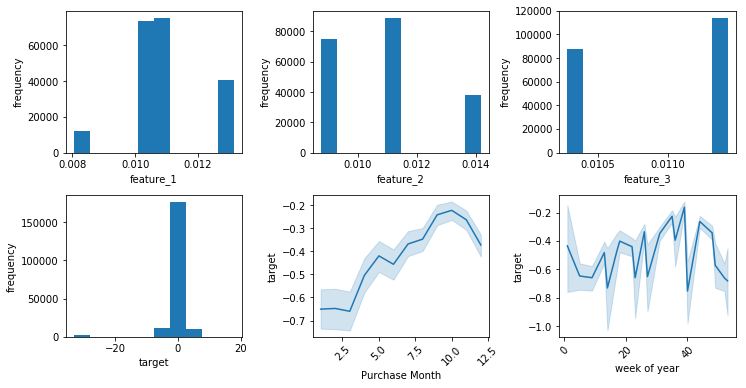

In [22]:
# plot
plt.figure(figsize=(12,6))
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.subplot(231)
plt.hist(train['feature_1'])
plt.xlabel('feature_1')
plt.ylabel('frequency')
plt.subplot(232)
plt.hist(train['feature_2'])
plt.xlabel('feature_2')
plt.ylabel('frequency')
plt.subplot(233)
plt.hist(train['feature_3'])
plt.xlabel('feature_3')
plt.ylabel('frequency')
plt.subplot(234)
plt.hist(train['target'])
plt.xlabel('target')
plt.ylabel('frequency')
plt.subplot(235)
ax = sns.lineplot(x = "month", y = "target", 
                  markers = True, dashes = False, data = train)
plt.xticks(rotation = 45)
ax.set_xlabel('Purchase Month')
plt.subplot(236)
ax = sns.lineplot(x = "weekofyear", y = "target", 
                  markers = True, dashes = False, data = train)
plt.xticks(rotation = 45)
ax.set_xlabel('week of year')

We can do the modeling now!

## Evaluation

In [23]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import neighbors

import gc
import matplotlib.pyplot as plt


In [24]:

train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train['target']
del train['target']

In [25]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,hist_year_nunique,...,new_purchase_date_uptonow,outliers,dayofweek,weekofyear,month,elapsed_time,hist_first_buy,new_first_buy,card_id_total,purchase_amount_total
0,2017-06-01,C_ID_92a2005557,0.013145,0.008752,0.011428,9,23,35,7,2,...,364.0,0,3,22,6,697,26,277.0,283.0,-179.212942
1,2017-01-01,C_ID_3d0044924f,0.010712,0.011385,0.010283,12,24,50,7,2,...,394.0,0,6,52,1,848,5,396.0,356.0,-214.362071
2,2016-08-01,C_ID_d639edf6cd,0.010610,0.008752,0.010283,10,14,22,7,2,...,365.0,0,0,31,8,1001,163,635.0,44.0,-29.867717
3,2017-09-01,C_ID_186d6a6901,0.010712,0.014166,0.010283,6,16,20,7,2,...,375.0,0,4,35,9,605,25,187.0,84.0,-54.145736
4,2017-11-01,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,4,22,17,7,2,...,365.0,0,2,44,11,544,11,121.0,169.0,-68.613893


### Let's try some models

In [26]:
print(target.values)

[-0.8203  0.3928  0.688  ...  0.0935 -4.676  -1.859 ]


In [31]:
def lightgbm(train, test, n_folds=5):
    param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train['outliers'].values)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

        num_round = 10000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
        oof[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_columns
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    valid_score = np.sqrt(mean_squared_error(oof, target))
    return feature_importance_df, valid_score

In [32]:
feature_importance, valid_score = lightgbm(train, test, n_folds=5)

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66718	valid_1's rmse: 3.72173
[200]	training's rmse: 3.59055	valid_1's rmse: 3.68849
[300]	training's rmse: 3.54543	valid_1's rmse: 3.67516
[400]	training's rmse: 3.51035	valid_1's rmse: 3.66704
[500]	training's rmse: 3.48126	valid_1's rmse: 3.66277
[600]	training's rmse: 3.45596	valid_1's rmse: 3.65911
[700]	training's rmse: 3.43348	valid_1's rmse: 3.65703
[800]	training's rmse: 3.4126	valid_1's rmse: 3.6562
[900]	training's rmse: 3.39378	valid_1's rmse: 3.65552
[1000]	training's rmse: 3.3764	valid_1's rmse: 3.65471
[1100]	training's rmse: 3.36	valid_1's rmse: 3.65401
[1200]	training's rmse: 3.34415	valid_1's rmse: 3.65349
Early stopping, best iteration is:
[1196]	training's rmse: 3.34468	valid_1's rmse: 3.6534
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66745	valid_1's rmse: 3.71596
[200]	training's rmse: 3.59041	valid_1's rmse: 3.68628
[30

In [34]:
print("the best validation RMSE score is {}".format(valid_score))

the best validation RMSE score is 3.6546012719621856


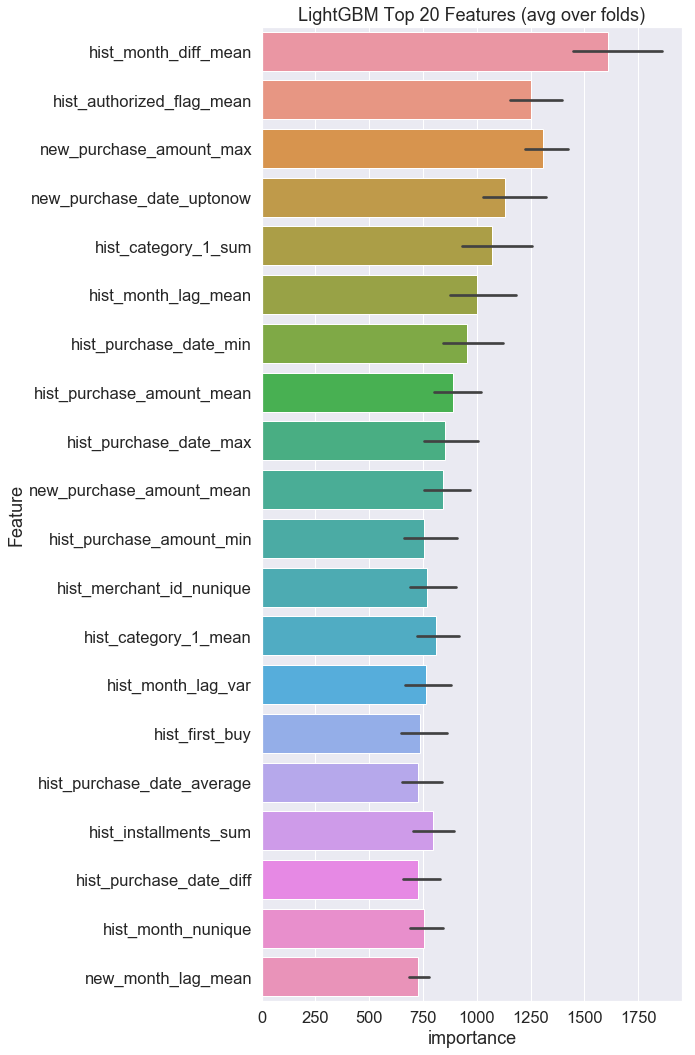

In [29]:
# plot the features
sns.set(font_scale=1.5)
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)

best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(10,15))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Top 20 Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')
